# Test different embedding sizes

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression

from glob import glob
import seaborn as sns
from collections import defaultdict

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [4]:
%matplotlib inline

In [5]:
np.random.seed(20171101)

## Read deepwalk embedding

In [6]:
features = {}
for i in [8, 16, 32, 64, 128, 256]:
    vecsize = i
    fname = "../embeddings/normal_{}.txt".format(vecsize)

    features[i] = pd.read_csv(
        fname, sep=" ", skiprows=1,
        names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
    )

## Read training data

In [7]:
traind = pd.read_csv("../data/clean_train.tsv", sep='\t')

In [8]:
traind.shape

(138639, 5)

In [9]:
traind.head(3)

,chemical_id,disease_id,category,chemical_uid,disease_uid
0,DB00035,ORPHA:100054,0,22434,989
1,DB00104,ORPHA:100054,0,3845,989
2,DB00115,ORPHA:100054,0,54459,989


## Subsample training data

In [10]:
trainpos = traind.query("category == 1")
K = 20

train = (trainpos
    .append(
        (traind
            .query("category == 0")
            .sample(len(trainpos) * K)
        )
    )
    .reset_index(drop=True)
)

In [11]:
train["category"].value_counts(normalize=True)

0    0.952381
1    0.047619
Name: category, dtype: float64

---

## Add in features

In [12]:
def add_features(df, features):
    return (df
        .merge(
            features, how="inner", left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how="inner", left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize):
    reg = add_features(df, features)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

In [13]:
tmp = {}
for vecsize, featdf in features.items():
    tmp[vecsize] = convolv_features(train, featdf, vecsize)

## Train classifier

In [14]:
models = {}
for vecsize, tdata in tmp.items():
    feat_cols = ["conv{}".format(i) for i in range(vecsize)]
    
    models[vecsize] = LogisticRegression(C=1e9)
    models[vecsize].fit(tdata[feat_cols], tdata["category"])

## Predict on holdout data

In [15]:
holdoutd = pd.read_csv("../data/clean_holdout.tsv", sep='\t')

In [16]:
holdoutd.head()

,chemical_id,disease_id,category,chemical_uid,disease_uid
0,DB00035,ORPHA:100050,0,22434,14962
1,DB00104,ORPHA:100050,0,3845,14962
2,DB00121,ORPHA:100050,0,41945,14962
3,DB00131,ORPHA:100050,0,7630,14962
4,DB00139,ORPHA:100050,0,31269,14962


In [17]:
results = {}
for vecsize, regmodel in models.items():
    test = convolv_features(holdoutd.drop("category", axis=1), features[vecsize], vecsize)
    
    featcols = ["conv{}".format(i) for i in range(vecsize)]
    ans = test.assign(predval = lambda df: regmodel.predict_proba(df[featcols])[:, 1])
    
    results[vecsize] = (ans
        [["chemical_id", "disease_id", "predval"]]
        .merge(
            holdoutd[["chemical_id", "disease_id", "category"]],
            how="inner", on=["chemical_id", "disease_id"]
        )
    )

In [18]:
sizes = sorted(list(results.keys()))

fusion = holdoutd[["chemical_id", "disease_id", "category"]]

for vecsize, res in results.items():
    fusion = (fusion
        .merge(
            res[["chemical_id", "disease_id", "predval"]],
            how="inner", on=["chemical_id", "disease_id"]
        )
        .rename(columns={"predval": "predval{}".format(vecsize)})
    )

In [19]:
fusion.head()

,chemical_id,disease_id,category,predval8,predval16,predval32,predval64,predval128,predval256
0,DB00035,ORPHA:100050,0,0.003705,0.005002,0.000194,0.000858,0.104410,1.933781e-04
1,DB00104,ORPHA:100050,0,0.002701,0.000611,0.001368,0.000001,0.000257,1.773933e-05
2,DB00121,ORPHA:100050,0,0.013626,0.041229,0.092607,0.000856,0.000400,7.034550e-06
3,DB00131,ORPHA:100050,0,0.003295,0.000772,0.000572,0.000001,0.000068,2.110119e-10
4,DB00139,ORPHA:100050,0,0.007337,0.031385,0.029978,0.000009,0.000006,4.937296e-06


## Draw ROC curves

In [20]:
def plot_roc(res_df, metrics, name_map, title="ROC"):
    auroc_results = defaultdict(dict)

    for metric in metrics:
        tmp = res_df[["category", metric]].sort_values(metric)
        fpr, tpr, thresh = roc_curve(tmp["category"], tmp[metric])

        auroc_results[metric]['fpr'] = fpr
        auroc_results[metric]['tpr'] = tpr
        auroc_results[metric]['thresh'] = thresh
        auroc_results[metric]['auc'] = auc(fpr, tpr)

    lw = 4
    x = [i for i in np.arange(0.0,1.01,.01)]
    plt.plot(x,x, 'k--', lw = 2)
    for metric in metrics:
        plt.plot(auroc_results[metric]['fpr'], auroc_results[metric]['tpr'], lw=lw,
                 label='{0} (area = {1:0.2f})'
                     .format(name_map[metric], auroc_results[metric]['auc']))
    fig = plt.gcf()
    fig.set_size_inches(8, 7)
    fig.set_tight_layout(False)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('FPR', size=20)
    plt.ylabel('TPR', size=20)
    plt.title(title, size=24)
    plt.legend(loc="lower right", frameon=True, shadow=True, prop={'size':16});

In [21]:
def plot_pr(res_df, metrics, name_map, title="ROC"):
    auroc_results = defaultdict(dict)

    for metric in metrics:
        tmp = res_df[["category", metric]]
        precision, recall, thresh = precision_recall_curve(tmp["category"], tmp[metric])

        auroc_results[metric]['precision'] = precision
        auroc_results[metric]['recall'] = recall
        auroc_results[metric]['thresh'] = thresh
        auroc_results[metric]['auc'] = auc(recall, precision)

    lw = 4
    x = [i for i in np.arange(0.0,1.01,.01)]

    for metric in metrics:
        plt.plot(auroc_results[metric]['recall'], auroc_results[metric]['precision'], lw=lw,
                 label='{0} (area = {1:0.2f})'
                     .format(name_map[metric], auroc_results[metric]['auc']))
    fig = plt.gcf()
    fig.set_size_inches(8, 7)
    fig.set_tight_layout(False)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('FPR', size=20)
    plt.ylabel('TPR', size=20)
    plt.title(title, size=24)
    plt.legend(loc="upper right", frameon=True, shadow=True, prop={'size':16});

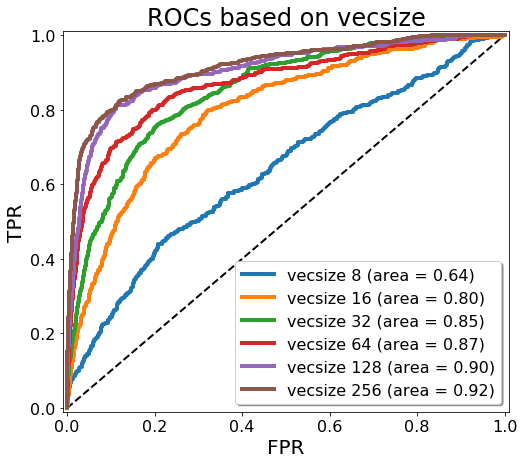

In [22]:
plot_roc(
    fusion,
    ["predval{}".format(i) for i in sizes],
    {
        "predval{}".format(i): "vecsize {}".format(i)
        for i in sizes
    },
    title="ROCs based on vecsize"
)

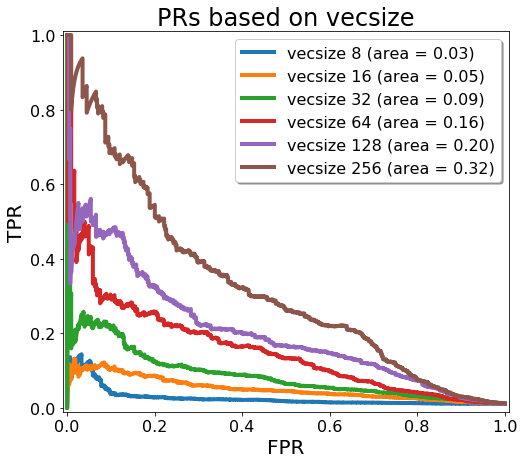

In [23]:
plot_pr(
    fusion,
    ["predval{}".format(i) for i in sizes],
    {
        "predval{}".format(i): "vecsize {}".format(i)
        for i in sizes
    },
    title="PRs based on vecsize"
)